# Libraries

In [ ]:
pip install PyYAML==3.12

In [ ]:
import keras

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [1]:
%matplotlib inline
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)
import os
import sys 
import pickle as pk
import  pickle
from datetime import datetime
import pandas as pd
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
#import nctoolkit as ncµ
import netCDF4 as nc4
import threading
import datetime as dt  # Python standard library datetime  module
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xbatcher as xb

import imageio
os.environ['PROJ_LIB'] = '/opt/python3-anaconda50-5.0.1-7ipsl.el6/share/proj'


from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from skimage.measure import block_reduce
from keras import callbacks as cbks



TensorFlow version:  2.2.0


In [2]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, MaxPooling3D, Dropout, BatchNormalization, Flatten, Conv2D, Conv3D, AveragePooling3D, LSTM, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History 

In [3]:
#reload support file 
import sys
import os
py_file_location = "/home/dbennour/DeepPV/"
sys.path.append(os.path.abspath(py_file_location))
import read_cloudalbedo_files, cloud_index_functions, write_cloud_index_files
import PV_Generator
py_file_location = "/home/dbennour/DeepPV/Unet_models/"
sys.path.append(os.path.abspath(py_file_location))
import UNet_model
from read_cloudalbedo_files import *
from PV_Generator import PV_DataGenerator
from UNet_model import *
import importlib
importlib.reload(read_cloudalbedo_files)
importlib.reload(PV_Generator)
importlib.reload(UNet_model)
# type(AECNN_model)
# importlib.reload(write_cloud_index_files)

<module 'UNet_model' from '/home/dbennour/DeepPV/Unet_models/UNet_model.py'>

# Load AECNN

In [4]:
path='/home/dbennour/DeepPV/AECNN_Model/'
aecnn=loadModel("AECNN_v4_2",path)

Yaml Model  AECNN_v4_2 .yaml loaded 
Weights  AECNN_v4_2 .h5 loaded 


# Model 2: CMV prediction

In [4]:
# data_path='/homedata/dbennour/DeepPV/CAL_CMV_slot/'
# data_path='/bdd/pegase/DEEPPV/CAL_CMV_slot/'
data_path='/net/nfs/ssd1/dbennour/CAL_CMV_slot/'
data_generator_train = PV_DataGenerator('train_data', data_path,to_fit=True,batch_size=16)
data_generator_val=PV_DataGenerator('val_data', data_path,to_fit=True,batch_size=16)
data_generator_test=PV_DataGenerator('test_data', data_path,to_fit=True,batch_size=16)

In [4]:
X_train, Y_train=generate_data(0,350,'train_data')



In [5]:
X_val,Y_val=generate_data(0,100,'val_data')

In [6]:
X_test,Y_test=generate_data(7124,7130,'test_data')

## U-Net

In [7]:
model=Unet_build()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 513, 513, 3, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 513, 513, 3,  650         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 513, 513, 3,  40          conv3d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 513, 513, 3,  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
# # To resume training
# from tensorflow.keras.models import model_from_yaml
# from tensorflow.keras.callbacks import *
# results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
# callbacks = [ EarlyStopping(patience=10, verbose=1),
#               ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#               cbks.ModelCheckpoint(results_dir+'Unet-weights.h5', 
#                                    monitor='val_loss', save_best_only=True),
#               TensorBoard(log_dir='/home/dbennour/tmp/Unet')]
# if results_dir is not None:
#     # Load model:
#     with open('/home/dbennour/DeepPV/Unet_models/Unet_v1_2.yaml',"r") as yaml_file:
#         model = model_from_yaml(yaml_file.read())
#     model.load_weights(results_dir+'Unet-weights.h5')
#     # Finding the epoch index from which we are resuming
# #     initial_epoch = get_init_epoch(results_dir)
# #     # Calculating the correct value of count
# #     count = initial_epoch*batches_per_epoch
# #     # Update the value of count in callback instance
# #     callbacks[1].count = count
# else:
#     model = build_model_func()
#     initial_epoch = 0
# sgd=SGD(momentum=0.9, nesterov=False)
# model.compile(optimizer=sgd, loss=root_mean_squared_error, metrics=['mse',R2])

In [ ]:
# # To resume training

# history=model.fit(data_generator_train,initial_epoch=6,epochs=10, callbacks=callbacks,validation_data=data_generator_val)

In [9]:
results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
callbacks = [ EarlyStopping(patience=10, verbose=1),
              ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001, verbose=1),
              cbks.ModelCheckpoint(results_dir+'Unet-weights.h5', 
                                   monitor='val_loss', save_best_only=True),
              TensorBoard(log_dir='/home/dbennour/tmp/Unet1')]
history=model.fit(X_train,Y_train,epochs=30, callbacks=callbacks,validation_data=(X_val,Y_val),batch_size=16)

Epoch 1/30
22/22 [==============================] - 204s 9s/step - loss: 0.1472 - root_mean_squared_error: 0.4710 - mse: 0.2234 - mae: 0.3406 - val_loss: 0.1364 - val_root_mean_squared_error: 0.4560 - val_mse: 0.2045 - val_mae: 0.3864 - lr: 0.0010
Epoch 2/30
22/22 [==============================] - 37s 2s/step - loss: 0.1110 - root_mean_squared_error: 0.3947 - mse: 0.1561 - mae: 0.3387 - val_loss: 0.1359 - val_root_mean_squared_error: 0.4622 - val_mse: 0.2086 - val_mae: 0.3993 - lr: 0.0010
Epoch 3/30
22/22 [==============================] - 38s 2s/step - loss: 0.0921 - root_mean_squared_error: 0.3526 - mse: 0.1244 - mae: 0.2900 - val_loss: 0.1764 - val_root_mean_squared_error: 0.5479 - val_mse: 0.2967 - val_mae: 0.4629 - lr: 0.0010
Epoch 4/30
22/22 [==============================] - 42s 2s/step - loss: 0.0853 - root_mean_squared_error: 0.3442 - mse: 0.1185 - mae: 0.2774 - val_loss: 0.1203 - val_root_mean_squared_error: 0.4437 - val_mse: 0.1926 - val_mae: 0.3668 - lr: 0.0010
Epoch 5/30


In [10]:
model.evaluate(X_test,Y_test)

2/2 [==============================] - 73s 36s/step - loss: 0.1408 - root_mean_squared_error: 0.5117 - mse: 0.2698 - mae: 0.3617


[0.1408361792564392,
 0.511693000793457,
 0.26979511976242065,
 0.36167603731155396]

In [ ]:
history=Unet_fit(model,data_generator_train,data_generator_val,1)

   2/2710 [..............................] - ETA: 124:23:56 - loss: 0.1280 - root_mean_squared_error: 0.4030 - mse: 0.1656 - mae: 0.2608

In [ ]:
model.evaluate(data_generator_test)

In [25]:
path='/home/dbennour/DeepPV/Unet_models/'
saveModel(model,"Unet_v3_1_1_train350_-2layers",path)

Yaml Model  Unet_v3_1_1_train350_-2layers .yaml saved to disk
Weights  Unet_v3_1_1_train350_-2layers .h5 saved to disk


# Results

In [4]:
path='/home/dbennour/DeepPV/Unet_models/'
model=loadModel("Unet_v3_1_train300_alllayers",path)

Yaml Model  Unet_v3_1_train300_alllayers .yaml loaded 
Weights  Unet_v3_1_train300_alllayers .h5 loaded 


In [94]:
# results_dir='/net/nfs/ssd1/dbennour/Resultats_ModelPV/'
# model.load_weights(results_dir+'Unet-weights.h5')

In [27]:
sgd=SGD(momentum=0.9, nesterov=False)
adam=Adam(clipnorm=0.9)
model.compile(optimizer=adam, loss=weightedLoss(0.1), metrics=[root_mean_squared_error,'mse','mae'])

In [ ]:
model.evaluate(data_generator_test)

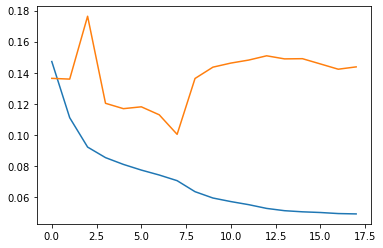

In [12]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
file_test=xr.open_dataset('/net/nfs/ssd1/dbennour/CAL_CMV_slot/test_data/CAL_CMV_20200801_1400_1415.nc')

In [ ]:
%matplotlib inline
show_CMV('202008011400',on_map=False);

In [5]:
def show_CMV_x_y(cmv_x,cmv_y,on_map,CAL):
    assert on_map in [True,False]
    lon_lat=xr.open_dataset('/net/nfs/ssd1/dbennour/lon_lat.nc')
    cmv_lon = lon_lat['lon'].values
    cmv_lat = lon_lat['lat'].values

    Cal_file=CAL_files()
#     fig=plt.figure(figsize=(8,8))
    xs = 1095
    ys = 5722
    lat_lon_SIRTA = tr.pixel_to_lat_lon_HR(xs,ys)
    lat_SIRTA = lat_lon_SIRTA[0] 
    lon_SIRTA = lat_lon_SIRTA[1]
    longitude=cmv_lon[:]
    latitude=cmv_lat[:]
    Arrows = read_cmv(cmv_x,cmv_y,longitude,latitude)
    U = Arrows['dy']
    V = Arrows['dx']
    lon = Arrows['longitude']
    lat = Arrows['latitude']
    m = Basemap(llcrnrlon =longitude.min(), llcrnrlat = latitude.min(), urcrnrlon = longitude.max(), urcrnrlat = latitude.max(),lon_0=0.0,lat_0= 0, resolution='l')
    m.drawcoastlines(color = 'y',linewidth = 1.0)
#     return lon,cmv_lon
    x0, y0 = m(longitude.min(), latitude.min())
    x1, y1 = m(longitude.max(), latitude.max())
    extent = (x0, x1, y0, y1)
    if on_map==True:
        im = plt.imshow(CAL,extent=extent,cmap = 'gray', vmax=80)
#         plt.colorbar(im)
    X,Y = np.meshgrid(lon,lat)
    lons,lats = m(X,Y)
    if len(lons) > 0:
        q = m.quiver(lon,lat,U,-V,color=(0,0.7,0),angles='xy', scale_units='xy',scale=5)
    else:
        print("No vectors found")
    a, b = m(lon_SIRTA,lat_SIRTA)
    m.plot(a,b,marker='o',color='r',markersize=5)

In [36]:
Y_pred=model.predict(X_test)

In [37]:
def plot_prediction(index,subset,model):
    
    assert subset in ['train','val','test']
    if subset=='train':
        X=X_train
        Y=Y_train
    elif subset=='val':
        X=X_val
        Y=Y_val
    else:
        X=X_test
        Y=Y_test
    Y_pred=model.predict(X)
    %matplotlib inline
    plt.tight_layout()
    fig=plt.figure(figsize=(20,20))
    fig.add_subplot(2,2,1)

    y1=Y[index,:,:,0,:].reshape((513,513))
    y2=Y[index,:,:,1,:].reshape((513,513))
    show_CMV_x_y(y1,y2,True,X[index,:,:,0,0])
    plt.title('True CMV');
    fig.add_subplot(2,2,2)

    y1=Y_pred[index,:,:,0,0].reshape((513,513))*5
    y2=Y_pred[index,:,:,1,0].reshape((513,513))*5
    show_CMV_x_y(y1,y2,True,X[index,:,:,0,0])
    plt.title('predicted CMV')

In [24]:
Y_pred.shape

(50, 513, 513, 2, 1)

In [22]:
np.unique(Y_pred[45,:,:,1,0]==Y_pred[5,:,:,1,0])

array([False])

In [ ]:
plot_prediction(45,'test',model)

<Figure size 432x288 with 0 Axes>

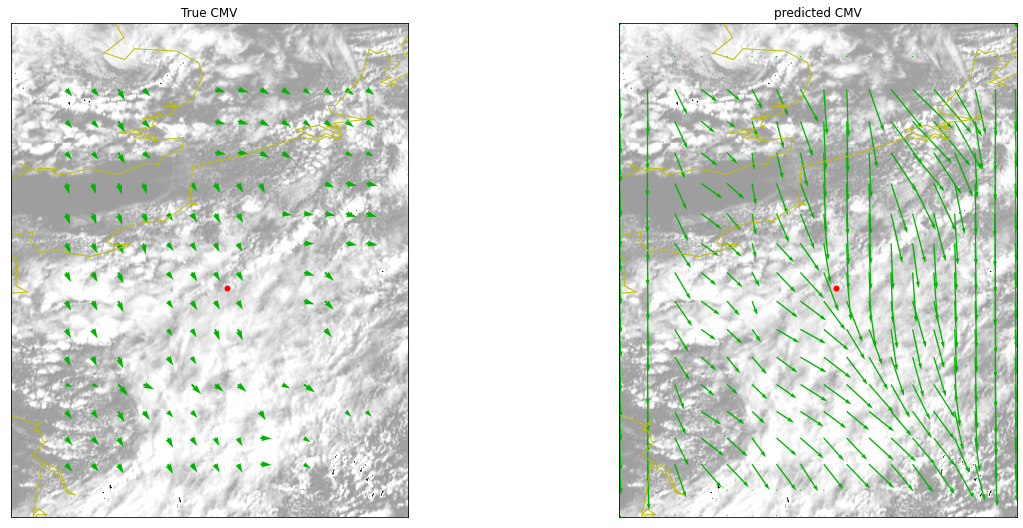

In [38]:
plot_prediction(5,'test',model)

In [ ]:
%matplotlib inline
plt.tight_layout()
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)

y1=Y_test[25,:,:,0,:].reshape((513,513))
y2=Y_test[25,:,:,1,:].reshape((513,513))
show_CMV_x_y(y1,y2,True,X_test[25,:,:,0,0])
fig.add_subplot(2,2,2)

y1=Y_pred[25,:,:,0,0].reshape((513,513))
y2=Y_pred[25,:,:,1,0].reshape((513,513))
show_CMV_x_y(y1,y2,True,X_test[25,:,:,0,0])

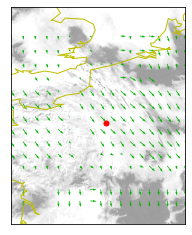

In [33]:
y1=Y_test[5,:,:,0,:].reshape((513,513))
y2=Y_test[5,:,:,1,:].reshape((513,513))
show_CMV_x_y(y1,y2,True,X_test[5,:,:,0,0])

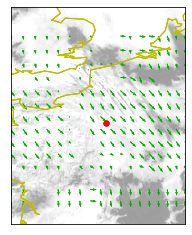

In [34]:
import matplotlib.animation as animation
for i in range(3):
#     im=plt.imshow(X_test[0,:,:,i,0],cmap='gray')
#     plt.title('true'+str(i))
    show_CMV_x_y(y1,y2,True,X_test[5,:,:,i,0])
    
    plt.savefig('Y_test_vectors'+str(i)+'.png')


In [35]:
with imageio.get_writer('Y_test_vectors.gif', mode='I') as writer:
    for filename in ['Y_test_vectors'+str(i)+'.png' for i in range(3)]:
        image = imageio.imread(filename)
#         
        writer.append_data(image)
        time.sleep(45)

In [17]:
Y_test[47,:,:,:,:].shape

(513, 513, 2, 1)

In [19]:
corr=np.corrcoef(Y_test[47,:,:,0,0],Y_pred[47,:,:,0,0])

In [ ]:
%matplotlib inline

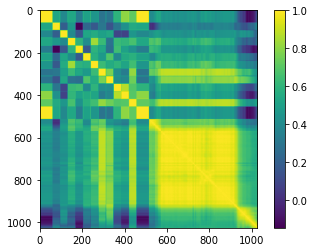

In [22]:
%matplotlib inline
plt.imshow(corr)
plt.colorbar()

In [ ]:
# np.unique(Y_pred[:,:,:,1,:])

In [26]:
for y in Y_pred[0:2,:,:,:,:]:
    print(y.shape)

(513, 513, 2, 1)
(513, 513, 2, 1)


In [8]:
test_name=sorted(os.listdir('/net/nfs/ssd1/dbennour/CAL_CMV_slot/test_data/'))[7124:7130]

In [9]:
test_name

['CAL_CMV_20200702_1330_1400.nc',
 'CAL_CMV_20200702_1345_1415.nc',
 'CAL_CMV_20200702_1400_1430.nc',
 'CAL_CMV_20200702_1415_1445.nc',
 'CAL_CMV_20200702_1430_1500.nc',
 'CAL_CMV_20200702_1445_1515.nc']

In [101]:
test_name=sorted(os.listdir('/net/nfs/ssd1/dbennour/CAL_CMV_slot/test_data/'))[7124:7130]
def predictions_to_nc_files(X_test,model,dirout,file_name_list):
    file_name_list=test_name
    Y_pred=model.predict(X_test)
    lon_lat=xr.open_dataset('/homedata/dbennour/DeepPV/lon_lat.nc')
    lon = lon_lat['lon'].values
    lat = lon_lat['lat'].values
    dirout=dirout

    for i in range(Y_pred.shape[0]):
        t0_30=dt.datetime.strptime(test_name[i][17:21],'%H%M')
        t0_15=t0_30+dt.timedelta(minutes=15)
        t0=t0_30+dt.timedelta(minutes=30)
        T0=dt.datetime.strftime(t0,'%H%M')
        T0_15=dt.datetime.strftime(t0_15,'%H%M')
        DS = xr.Dataset({

            'CMV_X': xr.DataArray(
                data = Y_pred[i,:,:,0,0],
                dims = ['x','y'],
                coords = {'lon':(['x','y'],lon),'lat':(['x','y'],lat)},
                attrs= {'long_name':'CMV_X','units':'-'}
            ),
            
            'CMV_Y': xr.DataArray(
                data = Y_pred[i,:,:,1,0],
                dims = ['x','y'],
                coords = {'lon':(['x','y'],lon),'lat':(['x','y'],lat)},
                attrs= {'long_name':'CMV_Y','units':'-'}
            )})
        fileout = dirout + 'CMV_BM_MAXCORRcst_'+ test_name[i][8:17] +T0_15+'_'+T0+'.nc'
        DS.to_netcdf(fileout)
        

In [102]:
predictions_to_nc_files(X_test,model)

In [6]:
true=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/raw_cloudindex_202007021400_to_t0.nc")
ex1=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/raw_cloudindex_202007021400_to_t300.nc")
ex2=xr.open_dataset("/homedata/dbennour/DeepPV/cloud_albedo_forecast/Unet_forecast/2020_07_02/raw_cloudindex_202007021400_to_t300.nc")

In [7]:
np.unique(ex1['Cloud_Albedo']==ex2['Cloud_Albedo'])

array([False,  True])

<Figure size 432x288 with 0 Axes>

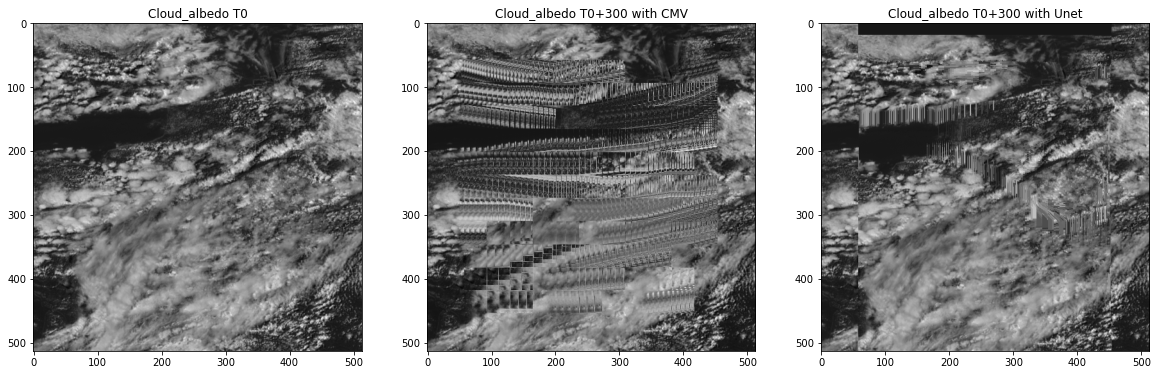

In [8]:
%matplotlib inline
plt.tight_layout()
# plt.figure(figsize=(12,12))
fig=plt.figure(figsize=(20,20))


ax1=fig.add_subplot(1,3,1)
im=plt.imshow(true['Cloud_Albedo'],cmap='gray');
# plt.colorbar(im);
plt.title('Cloud_albedo T0');
plt.subplot(132)
im=plt.imshow(ex1['Cloud_Albedo'],cmap='gray');
# plt.colorbar(im);
plt.title('Cloud_albedo T0+300 with CMV');
plt.subplot(133)
im=plt.imshow(ex2['Cloud_Albedo'],cmap='gray');
# plt.colorbar(im);
plt.title('Cloud_albedo T0+300 with Unet');

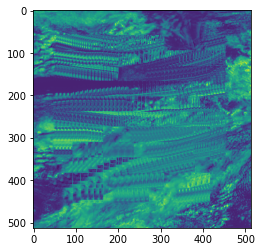

In [31]:
import matplotlib.animation as animation
sys.path.append('/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/')
path='/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/'
for file in (os.listdir('/homedata/dbennour/DeepPV/cloud_albedo_forecast/raw_forecast/')):
    im=plt.imshow(xr.open_dataset(path+file)['Cloud_Albedo'])
#     plt.title('true'+str(i))
   
    
    plt.savefig(file+'.png')

In [ ]:
"/home/dbennour/DeepPV/Unet_models/raw_cloudindex_202007021400_to_t0.nc.png"

In [32]:
with imageio.get_writer('forecast_CMV.gif', mode='I') as writer:
    for filename in ['raw_cloudindex_202007021400_to_t'+str(i)+'.nc'+'.png' for i in range(0,315,15)]:
        image = imageio.imread(filename)
#         
        writer.append_data(image)
        time.sleep(25)

In [7]:
X_test.shape

(6, 513, 513, 3, 1)

In [26]:
start_time='202007021400'
start_time[8:]
results=[i for i in test_name if i.startswith('CAL_CMV_'+start_time[:8]+'_'+start_time[8:])]

In [28]:
test_name.index(results[0])

2

In [25]:
'CAL_CMV_'+start_time[:8]+'_'+start_time[8:]

'CAL_CMV_20200702_1200'

In [5]:
horizon=60
print('Cloud_albedo T0 + ',horizon,'min')

Cloud_albedo T0 +  60 min


In [ ]:
def prevision_chain(X_test,Y_test,model,nc_prediction_dirout,file_name_list,start_time,horizon):
    predictions_to_nc_files(X_test,model,dirout,file_name_list)
    start_time_name_file=[i for i in test_name if i.startswith('CAL_CMV_'+start_time[:8]+'_'+start_time[8:])]
    index=file_name_list.index(start_time_name_file[0])
    fig=plt.figure(figsize=(20,20))
    
    ax1=fig.add_subplot(2,3,1)
    im1=ax1.imshow(X_test[index,:,:,2,0])
    ax1.set_title('Cloud_albedo T0')
    
    t0=dt.datetime.strptime(start_time,'%Y%m%H%M')
    forecast_time=t0+dt.timedelta(minutes=horizon)
    forecast_time_str=dt.datetime.strftime(forecast_time,'%Y%m%H%M')
    forecast_time_name_file=[i for i in test_name if i.startswith('CAL_CMV_'+forecast_time_str[:8]+'_'+forecast_time_str[8:])]
    forecast_index=file_name_list.index(forecast_time_name_file[0])
    ax2=fig.add_subplot(2,3,2)
    im2=ax2.imshow(X_test[forecast_index,:,:,2,0])
    ax2.set_title('Cloud_albedo T0+',horizon,'min')
    
    os.system(' e4cast_solar_DB.py sirtaDB.cfg'+start_time) 
    ax3=fig.add_subplot(2,3,3)
    y1=Y_test[start_time,:,:,0,:].reshape((513,513))
    y2=Y_test[start_time,:,:,1,:].reshape((513,513))
    show_CMV_x_y(y1,y2,True,X_test[start_time,:,:,0,0])
    ax3.set_title('CMV T0/T0+15')    
    #copy CMV start_time to /bdd/pegase/CMV/SirtaDB/mv
    os.system('mv /bdd/pegase/CMV/SirtaDB/mv/*.nc /homedata/dbennour/DeepPV/cloud_albedo_forecast/Real_CMV/')
    
    
    os.system('module load python/3.6-anaconda50')
    os.system('source activate deep_python')
    os.system(' e4cast_solar_DB.py sirtaDB.cfg'+start_time) 
    